 Playing with dimensionality reduction and machine learning

In [1]:
import sys, os
import numpy as np
import _fj
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
fast_crawling_id = 2924
track = _fj.trackload([fast_crawling_id])[0]
ltrack = _fj.lintrackload([fast_crawling_id])[0]
print()
print('candidate track has {} timesteps and {} linearised steps'.format(
    track['time'].size, len(ltrack.step_idx)
))


100%|██████████| 1/1 [00:00<00:00, 2882.68it/s]
candidate track has 2080 timesteps and 271 linearised steps



track columns
('time', 'x', 'y', 'trail_x', 'trail_y', 'center_x', 'center_y', 'orientation', 'length', 'width', 'eccentricity', 'ax_x', 'ax_y', 'z', 'trail_z')


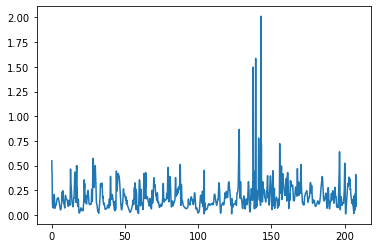

In [3]:
print('track columns')
print(track.get_dtype().names)

time = track['time']
velocity = track.get_head_v()
track_speed = np.linalg.norm(velocity, axis=1)
plt.plot(time[1:]-time[0], track_speed)


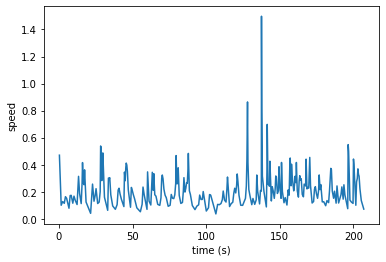

In [4]:

step_velocity = ltrack.get_step_velocity()
step_speed = np.linalg.norm(step_velocity, axis=1)
step_dt = ltrack.get_step_dt()
step_time = np.cumsum(step_dt)

ax = plt.gca()
ax.set_xlabel('time (s)')
ax.set_ylabel('speed')
ax.plot(step_time, step_speed)


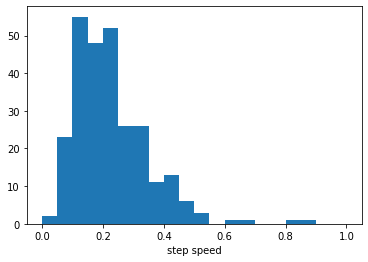

In [5]:
ax = plt.gca()
ax.hist(step_speed, bins=20, range=(0,1.0))
ax.set_xlabel('step speed')
plt.show()


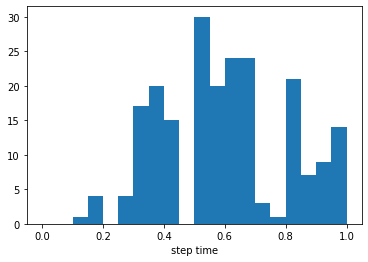

In [6]:
ax = plt.gca()
ax.hist(step_dt, bins=20, range=(0,1.0))
ax.set_xlabel('step time')
plt.show()


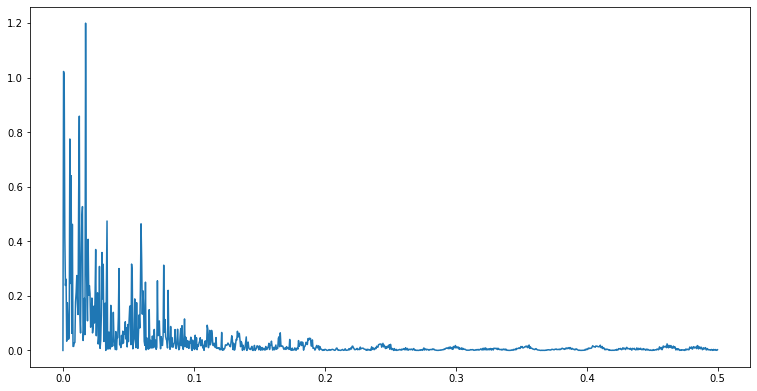

In [7]:
# power spectral density
f, Pxx = scipy.signal.periodogram(track_speed)
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1]) 
ax.plot(f, Pxx)
plt.show()


 this track as some irregular periodicity
 try DFT and then reconstructing the speed profile

In [8]:
# odd numbers are awkward
speed = track_speed[:-1]
time = track['time'][:-1]
print('input shape')
print(speed.shape, time.size)

# wait. step_speed are not regular samples so does this even make sense?
dft = np.fft.rfft(speed)
print('dft shape')
print(dft.size)
dftcut = dft[:dft.size//2]
# choosing the first m coefficients
dftcut = dft[:20]
print('after cutting ', dftcut.size)
# dft is ordered with largest frequency first
# reduce dimension ...

# print(ff)

recover = np.fft.irfft(dft, n=speed.size)
approx_recover = np.fft.irfft(dftcut, n=speed.size)
print('recovered size', approx_recover.size)

# print(recover)


input shape
(2078,) 2079
dft shape
1040
after cutting  20
recovered size 2078


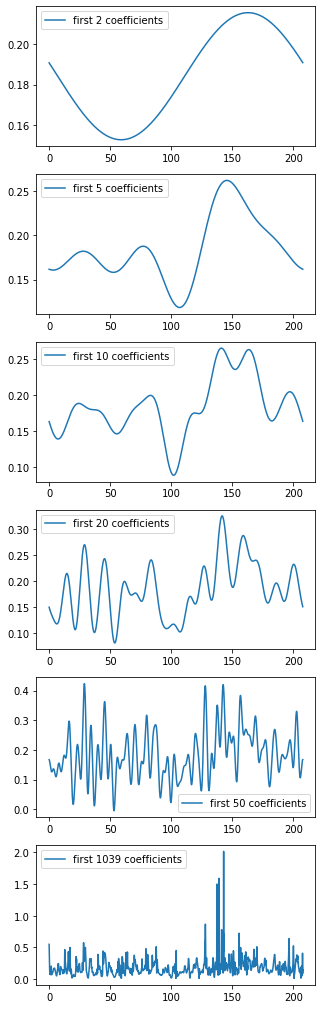

In [9]:
cutlist = [2,5,10,20,50,speed.size//2]
n = len(cutlist)
fig, axes = plt.subplots(len(cutlist),1, figsize=(5,n*3))
labelform = 'first {:d} coefficients'
for i,ax in enumerate(axes):
    cut = cutlist[i]
    cut_recover = np.fft.irfft(dft[:cut], n=speed.size)
    ax.plot(time[1:]-time[0], cut_recover, label=labelform.format(cut))
    ax.legend()
plt.show()


In [10]:
# 
def inversedft(dft, lcoef, n):
    # lcoef is a set of k values 
    # n is the output size
    # M = len(lcoef)
    N = len(dft)
    idft = np.empty(n)
    for i in range(n):
        idft[i] = 1/N * np.sum([dft[k]*np.exp((1j * 2 * np.pi * i * k)/N)
            for k in lcoef])
    return idft

abscoef = np.absolute(dft)
sortcoefidx = np.argsort(abscoef)[::-1]
n = 5
largestk = sortcoefidx[:n]
print('k', largestk)
largest = dft[sortcoefidx[:n]]

l_recover = inversedft(dft, largestk, n=speed.size)

k [ 0 36  1  2 26]
<ipython-input-10-78343278d3df>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  idft[i] = 1/N * np.sum([dft[k]*np.exp((1j * 2 * np.pi * i * k)/N)


In [11]:

# plt.plot(time[1:], l_recover)
# plt.show()

